In [ ]:
# =========================
# 0) PERSIAPAN & IMPOR
# =========================
# pip install torch torchvision scikit-learn matplotlib pillow
import os, random, math, itertools
from pathlib import Path
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, glob, shutil, random
from pathlib import Path
from sklearn.model_selection import train_test_split

# === KONFIGURASI ===
SEED = 42
SRC = Path("/content/drive/MyDrive/KlasifikasiSawit/Dataset")   # ganti ke folder sumber Anda
DST = Path("/content/drive/MyDrive/KlasifikasiSawit/Dataset/data_cls")
CLASSES = ["unripe", "ripe"] # 0=unripe, 1=ripe
SPLIT = (0.70, 0.15, 0.15)   # train, val, test

random.seed(SEED)

# siapkan folder tujuan
for sp in ["train","val","test"]:
    for c in CLASSES:
        (DST/sp/c).mkdir(parents=True, exist_ok=True)

# kumpulkan path & label
X, y = [], []
ex = (".jpg", ".jpeg", ".png", ".bmp")
for i, c in enumerate(CLASSES):
    for p in glob.glob(str(SRC/c/"*")):
        if p.lower().endswith(ex):
            X.append(p); y.append(i)

# sanity check
assert len(X) > 0, "Folder kosong? Pastikan dataset_root/unripe & ripe berisi gambar."

# train vs (val+test)
test_size = SPLIT[1] + SPLIT[2]
X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=test_size, random_state=SEED, stratify=y)

# val vs test (proporsi sama)
val_ratio = SPLIT[1] / (SPLIT[1] + SPLIT[2])
X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=(1 - val_ratio), random_state=SEED, stratify=y_tmp)

def move(files, labels, split):
    cnt = {c:0 for c in CLASSES}
    for p, lab in zip(files, labels):
        c = CLASSES[lab]
        dst = DST/split/c/Path(p).name
        shutil.copy2(p, dst)
        cnt[c] += 1
    print(f"[{split}] {cnt}")

move(X_tr, y_tr, "train")
move(X_val, y_val, "val")
move(X_te,  y_te,  "test")
print("[DONE] Split klasifikasi → data_cls/")


[train] {'unripe': 611, 'ripe': 700}
[val] {'unripe': 131, 'ripe': 150}
[test] {'unripe': 131, 'ripe': 151}
[DONE] Split klasifikasi → data_cls/


In [ ]:
# Seed untuk reprodusibilitas
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# =========================
# 1) KONFIGURASI
# =========================
DATA_ROOT = "/content/drive/MyDrive/KlasifikasiSawit/Dataset/data_cls"  # ubah jika path berbeda
IMG       = 224             # pakai 224 agar ringan untuk CNN dari nol
BATCH     = 32
EPOCHS    = 60
LR        = 2e-3
WD        = 1e-4
PATIENCE  = 8               # early stopping
device    = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [ ]:
# =========================
# 2) AUGMENTASI & NORMALISASI
#    - Disetel agar tahan latar (tanah vs kanopi) & cahaya
#    - Hue kecil (0.03) agar semantik warna tidak rusak
# =========================
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG, scale=(0.6,1.0), ratio=(0.8,1.2)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomPerspective(distortion_scale=0.05, p=0.2),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.35, contrast=0.35, saturation=0.25, hue=0.03),
    transforms.GaussianBlur(3),
    transforms.RandomAdjustSharpness(1.5, p=0.2),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.25, scale=(0.02,0.10), ratio=(0.3,3.3), value="random"),
])

eval_tf = transforms.Compose([
    transforms.Resize(int(IMG*1.1)),
    transforms.CenterCrop(IMG),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [ ]:
# =========================
# 3) DATASET & DATALOADER
# =========================
train_ds = datasets.ImageFolder(Path(DATA_ROOT)/"train", transform=train_tf)
val_ds   = datasets.ImageFolder(Path(DATA_ROOT)/"val",   transform=eval_tf)
test_ds  = datasets.ImageFolder(Path(DATA_ROOT)/"test",  transform=eval_tf)

CLASSES = train_ds.classes  # contoh: ['ripe','unripe'] (urut alfabet)
print("Classes:", CLASSES)
class_to_idx = train_ds.class_to_idx
positive_idx = class_to_idx.get("ripe", 1)  # untuk ROC (anggap 'ripe' = positif)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=4, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)


Classes: ['ripe', 'unripe']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# =========================
# 4) BOBOT KELAS (imbalance handling)
# =========================
counts = np.bincount(train_ds.targets)
class_weights = torch.tensor(1.0/(counts + 1e-6), dtype=torch.float32)
class_weights = (class_weights / class_weights.mean()).to(device)
print("Train counts:", dict(zip(CLASSES, counts)))

Train counts: {'ripe': np.int64(700), 'unripe': np.int64(611)}


In [ ]:
# =========================
# 5) MODEL CNN STANDAR (DARI NOL)
#    - Blok Conv-BN-ReLU + MaxPool
#    - Dropout untuk regularisasi
# =========================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # 224x224x3
        self.features = nn.Sequential(
            # Block 1: 224 -> 112
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32,32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 2: 112 -> 56
            nn.Conv2d(32,64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64,64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 3: 56 -> 28
            nn.Conv2d(64,128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128,128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 4: 28 -> 14
            nn.Conv2d(128,256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256,256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 5: 14 -> 7
            nn.Conv2d(256,512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512,512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # output approx 7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512*7*7, 512), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=len(CLASSES)).to(device)


In [ ]:
# =========================
# 6) LOSS, OPTIMIZER, SCHEDULER
# =========================
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


In [ ]:
# =========================
# 7) FUNGSI LATIH/VALIDASI
# =========================
def train_one_epoch(model, loader):
    model.train()
    total_loss, total_n = 0.0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        total_n += y.size(0)
    return total_loss/total_n

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, total_n = 0.0, 0
    correct = 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total_loss += loss.item() * y.size(0)
        total_n += y.size(0)
    return total_loss/total_n, correct/total_n


In [ ]:
# =========================
# 8) TRAINING + EARLY STOPPING
# =========================
best_state, best_val_acc = None, 0.0
best_val_loss, no_improve = float("inf"), 0

# Lists to store metrics for plotting
train_losses, val_losses, val_accuracies = [], [], []

for ep in range(1, EPOCHS+1):
    tr_loss = train_one_epoch(model, train_dl)
    val_loss, val_acc = evaluate(model, val_dl)
    scheduler.step(val_loss)

    # Store metrics
    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {ep:02d}/{EPOCHS} | train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")

    # simpan model jika membaik
    if val_acc > best_val_acc or val_loss < best_val_loss:
        best_val_acc = max(best_val_acc, val_acc)
        best_val_loss = min(best_val_loss, val_loss)
        best_state = {k:v.detach().cpu() for k,v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping.")
            break

# Muat bobot terbaik
if best_state is not None:
    model.load_state_dict(best_state)
os.makedirs("artifacts", exist_ok=True)
torch.save(model.state_dict(), "artifacts/simplecnn_ripe_unripe.pt")
print("Best Val Acc:", best_val_acc)

Epoch 01/60 | train_loss=5.2451 | val_loss=0.8107 | val_acc=0.4662
Epoch 02/60 | train_loss=0.9738 | val_loss=0.4933 | val_acc=0.7438
Epoch 03/60 | train_loss=0.5846 | val_loss=0.4110 | val_acc=0.8470
Epoch 04/60 | train_loss=0.5170 | val_loss=0.3601 | val_acc=0.8434
Epoch 05/60 | train_loss=0.5389 | val_loss=0.3559 | val_acc=0.8577
Epoch 06/60 | train_loss=0.4903 | val_loss=0.3197 | val_acc=0.8790
Epoch 07/60 | train_loss=0.4768 | val_loss=0.3235 | val_acc=0.8790
Epoch 08/60 | train_loss=0.4514 | val_loss=0.6839 | val_acc=0.7189
Epoch 09/60 | train_loss=0.4246 | val_loss=0.2289 | val_acc=0.9253
Epoch 10/60 | train_loss=0.4298 | val_loss=0.2633 | val_acc=0.9039
Epoch 11/60 | train_loss=0.4014 | val_loss=0.2485 | val_acc=0.8897
Epoch 12/60 | train_loss=0.4107 | val_loss=0.3736 | val_acc=0.8363
Epoch 13/60 | train_loss=0.4036 | val_loss=0.3792 | val_acc=0.8292
Epoch 14/60 | train_loss=0.3719 | val_loss=0.2331 | val_acc=0.9217
Epoch 15/60 | train_loss=0.3214 | val_loss=0.2690 | val_acc=0.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24/60 | train_loss=0.2497 | val_loss=0.1421 | val_acc=0.9466
Epoch 25/60 | train_loss=0.2597 | val_loss=0.1255 | val_acc=0.9502


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26/60 | train_loss=0.2425 | val_loss=0.0929 | val_acc=0.9751
Epoch 27/60 | train_loss=0.2352 | val_loss=0.2161 | val_acc=0.9075
Epoch 28/60 | train_loss=0.2510 | val_loss=0.1504 | val_acc=0.9359
Epoch 29/60 | train_loss=0.2530 | val_loss=0.1575 | val_acc=0.9502
Epoch 30/60 | train_loss=0.2359 | val_loss=0.2109 | val_acc=0.9110
Epoch 31/60 | train_loss=0.1969 | val_loss=0.1509 | val_acc=0.9431
Epoch 32/60 | train_loss=0.2072 | val_loss=0.1195 | val_acc=0.9431
Epoch 33/60 | train_loss=0.2169 | val_loss=0.0944 | val_acc=0.9680
Epoch 34/60 | train_loss=0.1911 | val_loss=0.1262 | val_acc=0.9573
Early stopping.
Best Val Acc: 0.9750889679715302


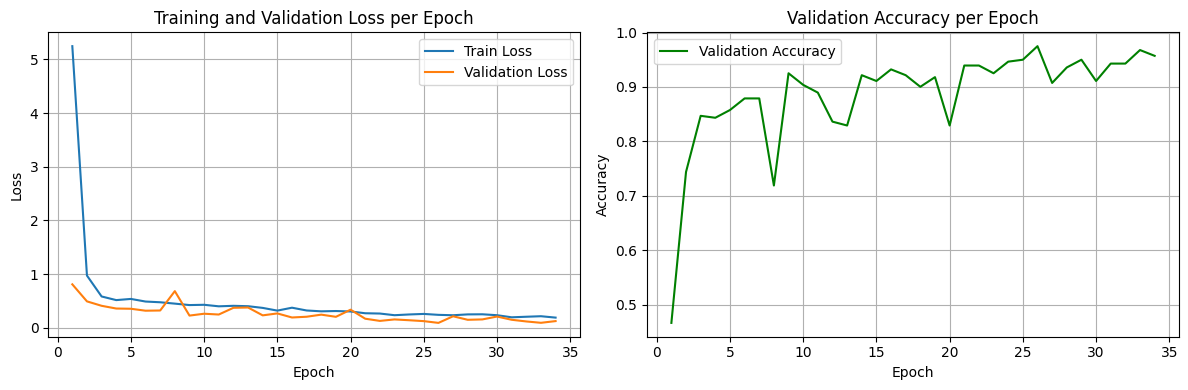

In [ ]:
# =========================
# 9) VISUALISASI METRIK PELATIHAN
# =========================
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


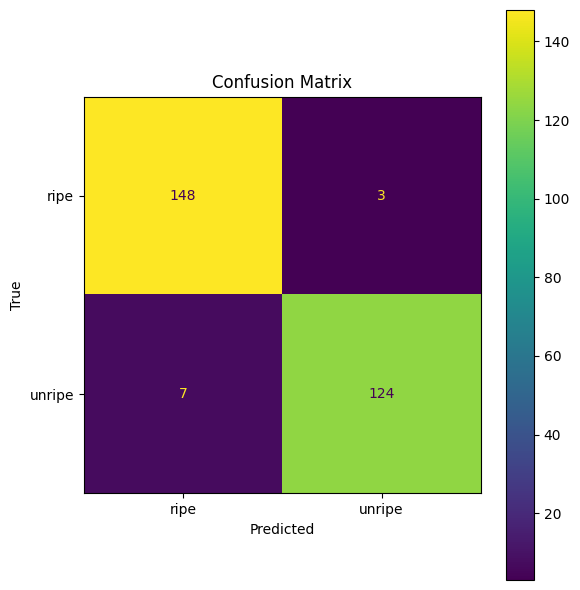

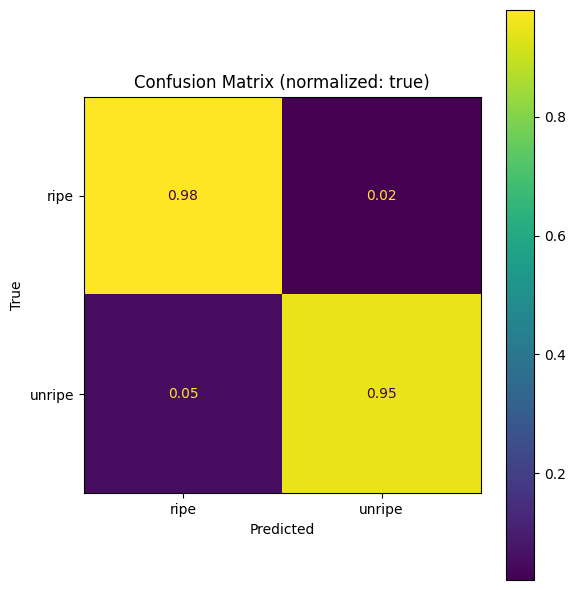

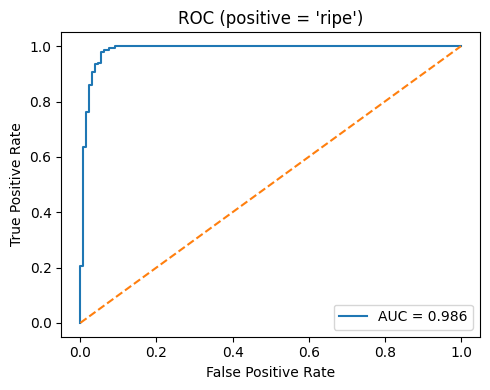

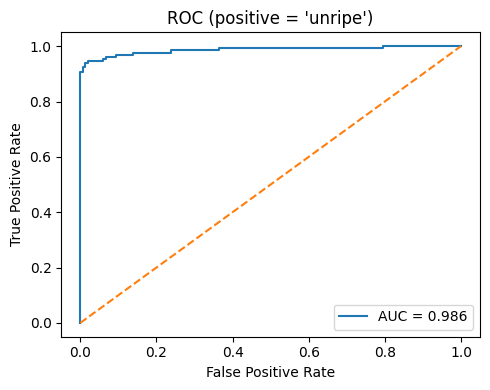


Classification Report:
              precision    recall  f1-score   support

        ripe       0.95      0.98      0.97       151
      unripe       0.98      0.95      0.96       131

    accuracy                           0.96       282
   macro avg       0.97      0.96      0.96       282
weighted avg       0.96      0.96      0.96       282



In [ ]:
# === Utils: Confusion Matrix & ROC ===
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report, cohen_kappa_score
import torch

def viz_confusion_matrix(y_true, y_pred, classes, out_path=None, normalize=None, figsize=(6,6)):
    """
    normalize: None | 'true' | 'pred' | 'all'
    """
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)), normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(ax=ax, colorbar=True, values_format=".2f" if normalize else "d")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_title("Confusion Matrix" + (f" (normalized: {normalize})" if normalize else ""))
    plt.tight_layout()
    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=150)
    plt.show(); plt.close(fig)

def viz_roc_curve_binary(y_true, y_score, classes, pos_label_name="ripe", out_path=None, figsize=(5,4)):
    # tentukan kelas positif
    pos_idx = classes.index(pos_label_name) if pos_label_name in classes else 1
    y_true_bin = (np.array(y_true) == pos_idx).astype(int)
    # if pos_label_name == "unripe":
    #     y_score = 1 - np.array(y_score) # Use 1 - probability for the other class

    fpr, tpr, _ = roc_curve(y_true_bin, np.array(y_score))
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    ax.plot([0,1],[0,1], "--")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC (positive = '{classes[pos_idx]}')")
    ax.legend(loc="lower right")
    plt.tight_layout()
    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=150)
    plt.show(); plt.close(fig)

# === Jika Anda belum punya y_prob, hitung ulang cepat dari model & test_dl ===
@torch.no_grad()
def predict_with_probs(model, loader, classes, device="cuda" if torch.cuda.is_available() else "cpu", pos_label_name="ripe"):
    model.eval()
    pos_idx = classes.index(pos_label_name) if pos_label_name in classes else 1
    y_true, y_pred, y_prob_ripe, y_prob_unripe = [], [], [], []
    for x, y in loader:
        logits = model(x.to(device))
        y_true += y.tolist()
        y_pred += logits.argmax(1).cpu().tolist()
        probs = torch.softmax(logits, dim=1).cpu().tolist()
        y_prob_ripe += [p[classes.index("ripe")] for p in probs]
        y_prob_unripe += [p[classes.index("unripe")] for p in probs]

    return y_true, y_pred, y_prob_ripe, y_prob_unripe


# --- (Re)compute if needed ---
y_true, y_pred, y_prob_ripe, y_prob_unripe = predict_with_probs(model, test_dl, CLASSES, device=device, pos_label_name="ripe")

# === Visualisasi & simpan ===
viz_confusion_matrix(y_true, y_pred, CLASSES, out_path="artifacts/confusion_matrix_raw.png", normalize=None)
viz_confusion_matrix(y_true, y_pred, CLASSES, out_path="artifacts/confusion_matrix_norm_true.png", normalize="true")
viz_roc_curve_binary(y_true, y_prob_ripe, CLASSES, pos_label_name="ripe", out_path="artifacts/roc_curve_ripe.png")
viz_roc_curve_binary(y_true, y_prob_unripe, CLASSES, pos_label_name="unripe", out_path="artifacts/roc_curve_unripe.png")


# === Classification Report ===
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))